#Yewno Data Challenge
##Helen Craig
##Jan 14, 2015
You are given a realworld
undirected semantic graph represented via an adjacency matrix
wherein links encode similarity between concepts. You are asked to explore the ( emerging )
properties of such a graph (aka network ) in terms of its embedding on a surface with a given
genus by using the techniques provided in the references attached [<a href="Exploring_complex_networks_via_embedding_on_surfaces.pdf">1</a> ,<a href="Random_and_frozen_states_in_complex_triangulations.pdf">2</a>]. You are also asked to
infer potential connections between properties of hyperbolic embeddings and semantic
information hidden in the network.

##Paper Summary
In the two papers given as reference, the authors explore complex networks by modeling the system as a statistical mechanical description and manipulate the system via a 'temperature'.

##Reproducing Results
The following code reproduces some of the methods used in the above mentioned papers:

In [124]:
import csv
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

###Function for loading the data

In [73]:
def loadData(name="net1.dat",n=10000):#this function loads the data
    entries = list(csv.reader(open(name, 'rb'),delimiter='\t'))[0:n]
    dic={}
    for entry in entries:
        dic[(entry[0],entry[1])]=entry[2]
    dicSingles={}#we create a dictionary where the keys are the
    for key in dic.keys():#various words and the items are the 
        if key[0] in dicSingles.keys():#words connected to the keys
            if key[1] not in dicSingles[key[0]]:
                dicSingles[key[0]].append(key[1])
        else:
            dicSingles[key[0]]=[key[1]]

        if key[1] in dicSingles.keys():
            if key[0] not in dicSingles[key[1]]:
                dicSingles[key[1]].append(key[0])
        else:
            dicSingles[key[1]]=[key[0]] 
    dicDoubles={}#we create a dictionary where the key is a edge
    for key in dicSingles.keys():#and the items are the 
        for item in dicSingles[key]:#
            a=key
            b=item
            if a>b:
                c=a
                a=b
                b=c 
            newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
            if (a,b) not in dicDoubles.keys():
                    dicDoubles[(a,b)]=newItems
    return (dicSingles,dicDoubles)

###Function for calculating the average k
Here k is the number of incident edges for a given vertex

In [9]:
def calcKavrg(dicSingles):
    tot=0
    for item in dicSingles.items():
        tot+=len(item[1])
    return float(tot)/float(len(dicSingles))

###Function for calculating energy of the graph
The energy is defined as: $E=\sum^n_{i=1}(k_i-\bar{k})^2$ where n is the number of vertices and $\bar{k}$ is the average k value.

In [7]:
def calcEnergy(dicSingles,kAvg):
    tot=0
    for item in dicSingles.items():
        tot+=pow(len(item[1])-kAvg,2)
    return tot

###Helper function for organizing keys for edge array

In [19]:
def reorder(a,b):
    if a>b:
        c=a
        a=b
        b=c
    return a,b

###Function for removing one edge and inserting another edge
This is the move T1 discussed in the linked papers.  Visually the move is:
<img src="T1.png">

In [99]:
def makeMove(dicSingles,dicDoubles,oldLink,newLink):
    del dicDoubles[oldLink]#delete the link
    dicSingles[oldLink[0]].remove(oldLink[1])#remove link
    dicSingles[oldLink[1]].remove(oldLink[0])#from the two previously linked nodes
    for item in dicSingles[oldLink[0]]:#for one of the old nodes
        a=oldLink[0]#remove the link to the third node
        b=item
        a,b=reorder(a,b)
        if (a,b) in dicDoubles.keys():
            if oldLink[1] in dicDoubles[(a,b)]:
                dicDoubles[(a,b)].remove(oldLink[1])
    for item in dicSingles[oldLink[1]]:#same for the other node
        a=oldLink[1]
        b=item
        a,b=reorder(a,b)
        if (a,b) in dicDoubles.keys():
            if oldLink[0] in dicDoubles[(a,b)]:
                dicDoubles[(a,b)].remove(oldLink[0])
    #########################################       
    dicSingles[newLink[0]].append(newLink[1])#add the new link to the 
    dicSingles[newLink[1]].append(newLink[0])#individual lists
    a=newLink[0]
    b=newLink[1]
    a,b=reorder(a,b)
    newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
    dicDoubles[(a,b)]=newItems#add to the link list and the third connections
    for item in dicSingles[newLink[0]]:
        a,b=reorder(item,newLink[0])
        newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
        dicDoubles[(a,b)]=newItems#add to the link list the any other new connections
    for item in dicSingles[newLink[1]]:
        a,b=reorder(item,newLink[1])
        newItems=list(set(dicSingles[a]).intersection(dicSingles[b]))
        dicDoubles[(a,b)]=newItems#same with the other new point      

###Function for stepping through the graph to make suggested moves.  
This function steps through the graph looking for edges where a T1 move is possible.  If one is found, the change in energy of such a move is calculated ($\Delta E=2(k_a+k_c-k_b-k_d)+4$) and is accepted with probability $\frac{1}{1+\exp{(\beta \Delta E)}}(1-\delta_{k_b,3})(1-\delta_{k_d,3})(1-\delta_{a,c})$ where $T=1/\beta$, a 'temperature' of the system.

In [217]:
def stepThroughGraph(dicSingles,dicDoubles,beta):
    totE=0
    totMoves=0
    oldKeys=dicDoubles.keys()#list of old links
    for oldKey in oldKeys:#step through them
        oldTriangles=dicDoubles[oldKey]#list of triangles that the link is a part of
        if len(dicSingles[oldKey[0]])>3 and len(dicSingles[oldKey[1]])>3 and len(oldTriangles)>1:
            for oldTriangleIndex in range(len(oldTriangles)):
                r1=random.randrange(0, len(oldTriangles))#randomly select two of the triangles
                r2=random.randrange(0, len(oldTriangles))
                if r1!=r2:#if they are not the same triangle
                    a,b=reorder(oldTriangles[r1],oldTriangles[r2])
                    if (a,b) not in dicDoubles.keys():#if the link does not already exist
                        ka=len(dicSingles[oldTriangles[r1]])
                        kc=len(dicSingles[oldTriangles[r2]])
                        kd=len(dicSingles[oldKey[0]])
                        kb=len(dicSingles[oldKey[1]])
                        deltaE=2*(ka+kc-kd-kb)+4#calc the change in energy
                        totE+=deltaE
                        if deltaE/beta>200:
                            prob=0
                        else:    
                            prob=1/(1+math.exp(deltaE/beta))
                        r=random.random()
                        totMoves+=1
                        if prob>r:#calc if we make the move
                                oldLink=oldKey
                                newLink=(oldTriangles[r1],
                                        oldTriangles[r2])#make the move
                                makeMove(dicSingles,dicDoubles,oldLink,newLink)
                                break;#exit the loop
    print float(totE)/float(totMoves)
    return totMoves


###Function for calculating the genus of a given graph

In [187]:
def calcGenus(dicSingles,dicDoubles):
    numVertices=len(dicSingles)
    numEdges=len(dicDoubles)
    numTriangles=0
    for key in dicDoubles.keys():
        numTriangles+=len(dicDoubles[key])
    return 1-(numVertices-numEdges+numTriangles/3)/2.0

###Load the file and calculate the average k and the energy of the system

In [240]:
dicSingles,dicDoubles=loadData("net1.dat",10000)#load data
kAvg=calcKavrg(dicSingles)#calc kAvg
print kAvg
print calcEnergy(dicSingles,kAvg)

5.10176017602
457570.348735


###function for calculating the number of vertices, edges, and triangles of a graph

In [237]:
def CalcVerticesEdgesTrianglesGenus(dicSingles,dicDoubles):
    numVertices=len(dicSingles)
    numEdges=len(dicDoubles)
    numTriangles=0
    for key in dicDoubles.keys():
        numTriangles+=len(dicDoubles[key])
    print "# vertices",numVertices
    print "# edges",numEdges
    print "# triangles",numTriangles,"/ 3 =",numTriangles/3
    print "# genus",1-(numVertices-numEdges+numTriangles/3)/2.0
CalcVerticesEdgesTrianglesGenus(dicSingles,dicDoubles)

# vertices 3636
# edges 9275
# triangles 7062 / 3 = 2354
# genus 1643.5


###running the code for different $\beta$

below is the code for running the simulation with different $\beta$ values.  Only 50 sweeps through the graph are made because of the long running time (~5min).  

In [246]:
betas=['10','1','0.1','0.01','0.001','0.000001']
steps=range(50)
energyArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
stepsArray={'10':[],'1':[],'0.1':[],'0.01':[],'0.001':[],'0.000001':[]}
for beta in betas:
    totSteps=0
    dicSingles,dicDoubles=loadData("net1.dat",10000)#load data
    for step in steps:
        totSteps+=stepThroughGraph(dicSingles,dicDoubles,float(beta))
        energyArray[beta].append(calcEnergy(dicSingles,kAvg)/len(dicSingles))
        stepsArray[beta].append(totSteps)
        print beta,step,totSteps,calcEnergy(dicSingles,kAvg), calcGenus(dicSingles,dicDoubles)

-27.3598448109
10 0 1031 358698.348735 2044.0
15.6427015251
10 1 1949 325038.348735 2177.5
39.6162361624
10 2 2762 312382.348735 2209.0
46.5824175824
10 3 3490 305430.348735 2222.0
53.6482939633
10 4 4252 302432.348735 2226.0
57.3443983402
10 5 4975 300616.348735 2229.5
52.5373961219
10 6 5697 299068.348735 2234.0
56.434192673
10 7 6434 298070.348735 2244.5
54.181294964
10 8 7129 296902.348735 2242.0
53.6992907801
10 9 7834 296138.348735 2248.0
52.3909348442
10 10 8540 295912.348735 2239.0
53.2877792378
10 11 9301 294568.348735 2247.0
54.9447513812
10 12 10025 294382.348735 2257.0
50.9319526627
10 13 10701 294202.348735 2257.5
49.8235294118
10 14 11381 293688.348735 2260.5
53.8565022422
10 15 12050 293470.348735 2256.0
52.7441176471
10 16 12730 293346.348735 2253.0
48.6464646465
10 17 13423 292782.348735 2270.0
47.3188180404
10 18 14066 292600.348735 2267.0
50.3757575758
10 19 14726 292370.348735 2276.0
51.0996978852
10 20 15388 292074.348735 2275.0
47.8874172185
10 21 15992 291918.348

###plot for different betas, evolution of energy versus steps.

From the plot below we see that the energy is still decreasing for the $\beta$'s, most notably for $\beta=10$.

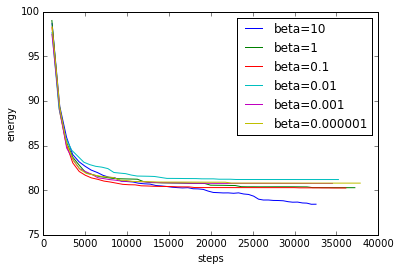

In [251]:
for beta in betas:
    plt.plot(stepsArray[beta],energyArray[beta],label='beta='+beta)
    plt.xlabel('steps')
    plt.ylabel('energy')
    plt.legend()
plt.show()

###The final energy versus $\beta$

The final energy decreases for smaller temperatures (larger $\beta$).

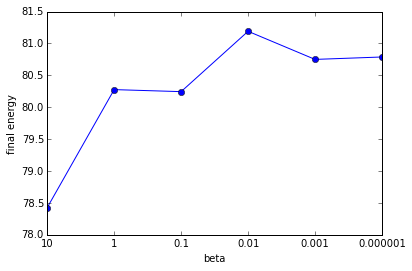

In [259]:
x=range(len(betas))
plt.plot(x,[energyArray[beta][-1] for beta in betas],'o-')
plt.xticks(x, betas)
plt.xlabel('beta')
plt.ylabel('final energy')

###Questions remaining:

As mentioned in the paper, "any network can be represented as a pruned triangulation of a
surface".  The network that I have is not a triangulation.  How do I deal with this in using the techniques described in the papers?



In [260]:
betas=['100']
steps=range(50)
energyArray={'100':[]}
stepsArray={'100':[]}
for beta in betas:
    totSteps=0
    dicSingles,dicDoubles=loadData("net1.dat",10000)#load data
    for step in steps:
        totSteps+=stepThroughGraph(dicSingles,dicDoubles,float(beta))
        energyArray[beta].append(calcEnergy(dicSingles,kAvg)/len(dicSingles))
        stepsArray[beta].append(totSteps)
        print beta,step,totSteps,calcEnergy(dicSingles,kAvg), calcGenus(dicSingles,dicDoubles)

-31.2561983471
100 0 1210 365028.348735 1876.5
5.50171232877
100 1 2378 337112.348735 2032.0
11.801432958
100 2 3355 321560.348735 2126.0
21.6655367232
100 3 4240 311816.348735 2168.5
31.7635705669
100 4 5069 309220.348735 2179.0
29.9925742574
100 5 5877 304068.348735 2203.5
30.9356568365
100 6 6623 300744.348735 2199.5
31.0416666667
100 7 7391 300232.348735 2206.5
26.2328966521
100 8 8078 297286.348735 2225.5
35.6732954545
100 9 8782 296118.348735 2224.0
30.3573487032
100 10 9476 295228.348735 2229.5
23.8921417565
100 11 10125 292786.348735 2236.5
27.3602391629
100 12 10794 292114.348735 2238.5
25.0764705882
100 13 11474 290380.348735 2221.5
26.7743813683
100 14 12161 287756.348735 2228.5
26.7680945347
100 15 12838 286836.348735 2248.0
25.7164869029
100 16 13487 283364.348735 2240.0
31.2378223496
100 17 14185 282434.348735 2243.0
31.3580980684
100 18 14858 281996.348735 2243.0
24.6315789474
100 19 15561 280228.348735 2250.5
30.4281437126
100 20 16229 279468.348735 2258.5
24.3360258481

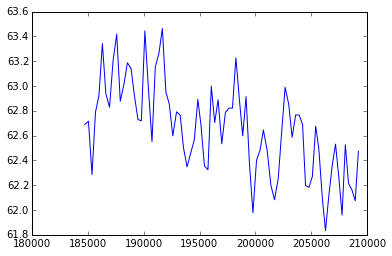

In [298]:
plt.plot(stepsArray['100'][-80:],energyArray['100'][-80:])

In [297]:
steps=range(30)
for beta in betas:
    for step in steps:
        totSteps+=stepThroughGraph(dicSingles,dicDoubles,float(100000))
        energyArray[beta].append(calcEnergy(dicSingles,kAvg)/len(dicSingles))
        stepsArray[beta].append(totSteps)
        print step,totSteps,calcEnergy(dicSingles,kAvg), calcGenus(dicSingles,dicDoubles)

-2.85350318471
0 200416 227182.348735 2391.0
2.14046822742
1 200715 227780.348735 2394.5
-9.92121212121
2 201045 227188.348735 2390.0
-1.5860058309
3 201388 226158.348735 2392.5
-2.02461538462
4 201713 225732.348735 2393.0
5.69788519637
5 202044 226350.348735 2394.5
3.12871287129
6 202347 227686.348735 2390.5
7.28253968254
7 202662 229030.348735 2389.5
-11.024691358
8 202986 228532.348735 2392.5
-10.9868421053
9 203290 227564.348735 2389.5
2.11285266458
10 203609 228218.348735 2392.5
0.885350318471
11 203923 228216.348735 2389.0
-9.34437086093
12 204225 227944.348735 2398.0
-0.142322097378
13 204492 226152.348735 2396.5
6.46405228758
14 204798 226096.348735 2390.0
1.7328990228
15 205105 226416.348735 2397.0
13.6466666667
16 205405 227890.348735 2397.0
-2.10144927536
17 205681 227232.348735 2399.5
-12.0802469136
18 206005 225756.348735 2400.0
-1.8102189781
19 206279 224824.348735 2398.5
4.26086956522
20 206578 225844.348735 2392.5
1.04180064309
21 206889 226752.348735 2393.5
-5.09965635

In [ ]:
steps=range(300)
beta=0.1
dicSingles2,dicDoubles2=loadData("net1.dat",10000)#load data
energyArray2=[]
stepsArray2=[]
betaMult=1.04
totSteps2=0
for step in steps:
    totSteps2+=stepThroughGraph(dicSingles2,dicDoubles2,beta)
    energyArray2.append(calcEnergy(dicSingles2,kAvg)/len(dicSingles2))
    stepsArray2.append(totSteps2)
    beta=beta*betaMult
    print step,beta,totSteps2,calcEnergy(dicSingles2,kAvg)/len(dicSingles2), calcGenus(dicSingles2,dicDoubles2)

-19.6137184116
0 0.104 1108 98.2536712692 1980.0
7.61087866109
1 0.10816 2064 88.4522411262 2183.5
42.2
2 0.1124864 2874 85.5738032824 2209.0
47.6290726817

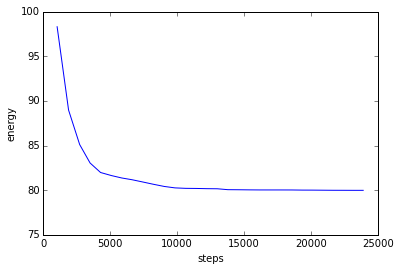

In [300]:
plt.plot(stepsArray2,energyArray2)
plt.xlabel('steps')
plt.ylabel('energy')